# `DSML Workshop 08` - Multiple Linear Regression and Polynomial Regression

In this workshop continue with hands-on machine learning focusing mostly on the non-linear regression example (polynomial regression) covererd previously in the lecture.

This workshop is structured as follows: 
1. Using multiple features in linear regression
1. Non-linear modeling and polynomial regression (by hand and in scikit learn)
1. Cross-validation techniques  


In [50]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime

%matplotlib inline

## Example: predicting peak electrical power

We will again work with our electric power example from last week which we retieved from PJM from the following link [here](https://dataminer2.pjm.com/feed/hrl_load_metered/definition)). The files we are loading are the raw files we downloaded from this source. The final input data for our code is `Pittsburgh_load_data.csv`.

In [52]:
df = pd.read_csv("Pittsburgh_load_data.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%d.%m.%Y")
df["Month"] = df["Date"].apply(lambda x: x.month)
df.head()

,Date,AVG,MAX,MIN,Total,High_temp,Avg_temp,Month
0,2013-01-01,1.598524,1.859947,0.001599,38.368031,0.0,-1.68,1
1,2013-01-02,1.809347,2.054215,0.001809,43.428194,-3.9,-6.58,1
2,2013-01-03,1.832822,2.049550,0.001833,43.991607,0.6,-6.12,1
3,2013-01-04,1.812699,2.008168,0.001813,43.508609,0.0,-1.95,1
4,2013-01-05,1.662036,1.838251,0.001662,39.892360,1.7,-1.47,1


**Recall from last week's workshop**: We fitted a linear model to the summer period of our electricity data. To do so we used `scikit learn` and obtained the following result:

In [53]:
# limit to summer month
df_summer = df[(df["Month"] > 5) & (df["Month"] < 9)]

In [54]:
X = df_summer["High_temp"].values.reshape((-1,1)) # if we pass a 1-feature array we need to re-shape it!
y = df_summer["MAX"]

[0.08385936] -0.08024740699314936


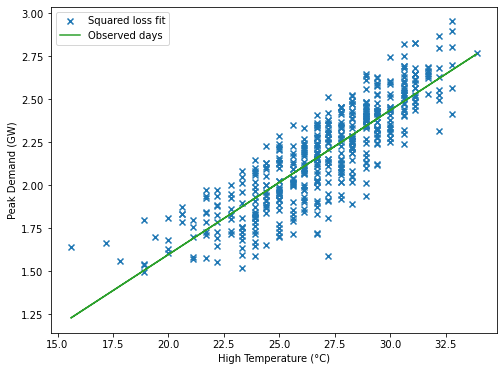

In [55]:
# initialize model
lin_mod = LinearRegression()

#train model
lin_mod.fit(X, y)

#make predictions using model
model_pred = lin_mod.predict(X)

# plot resulzts
plt.figure(figsize = (8,6))
plt.scatter(X, y, marker="x")
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.plot(X, model_pred, c='C2')
plt.legend(['Squared loss fit','Observed days'])
print(lin_mod.coef_, lin_mod.intercept_)

## Multi-dimensional linear regression

How do we now incorporate multiple features into our model? Essentially all we nee to do is pass a larger feature verctor to our model. To see this let us again consider the example of electricity demand:

We assume that consumption behavior is differnt on weekends. Can you think of the key reasons why this might be the case?

Let us create a boolean indicator feature entitled `IsWeekday` that returns True if the day is a weekday and False if it falls on a weekend.

In [56]:
df_summer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459 entries, 151 to 1702
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       459 non-null    datetime64[ns]
 1   AVG        459 non-null    float64       
 2   MAX        459 non-null    float64       
 3   MIN        459 non-null    float64       
 4   Total      459 non-null    float64       
 5   High_temp  459 non-null    float64       
 6   Avg_temp   459 non-null    float64       
 7   Month      459 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 32.3 KB


In [58]:
# add the weekday column to our data frame
# note: we are using here the very powerful map() function, which returns a list of the results 
# after applying the given function to each item of a given iterable (list, tuple etc.)

df_summer["Weekday"] = df_summer["Date"].apply(lambda dt: dt.weekday())

In [60]:
df_summer.head(5)

,Date,AVG,MAX,MIN,Total,High_temp,Avg_temp,Month,Weekday
151,2013-06-01,1.946586,2.298662,0.001947,46.722317,29.4,24.79,6,5
152,2013-06-02,1.787233,2.026075,0.001787,42.897404,26.7,23.46,6,6
153,2013-06-03,1.664323,1.832544,0.001664,39.947248,20.6,17.11,6,0
154,2013-06-04,1.581505,1.827014,0.001582,37.959541,22.2,15.40,6,1
155,2013-06-05,1.736095,2.109310,0.001736,41.670127,26.7,19.91,6,2


In [61]:
# alternatively you can also define you own function

def weekday_check (dt):
    
    day_number = dt.weekday()
    
    if day_number <=4:
        return 1
    else:
        return 0

df_summer["IsWeekday"] = df_summer["Date"].apply(lambda dt: weekday_check(dt))

In [63]:
# alternative
df_summer["IsWeekday"] = df_summer["Weekday"].apply(lambda x: 1 if x<=4 else 0)

In [64]:
df_summer.head(10)

,Date,AVG,MAX,MIN,Total,High_temp,Avg_temp,Month,Weekday,IsWeekday
151,2013-06-01,1.946586,2.298662,0.001947,46.722317,29.4,24.79,6,5,0
152,2013-06-02,1.787233,2.026075,0.001787,42.897404,26.7,23.46,6,6,0
153,2013-06-03,1.664323,1.832544,0.001664,39.947248,20.6,17.11,6,0,1
154,2013-06-04,1.581505,1.827014,0.001582,37.959541,22.2,15.40,6,1,1
155,2013-06-05,1.736095,2.109310,0.001736,41.670127,26.7,19.91,6,2,1
156,2013-06-06,1.734597,1.923417,0.001735,41.633988,21.7,19.28,6,3,1
157,2013-06-07,1.595062,1.799999,0.001595,38.284876,18.9,16.73,6,4,1
158,2013-06-08,1.415416,1.568676,0.001415,33.972964,21.1,16.87,6,5,0
159,2013-06-09,1.549465,1.915678,0.001549,37.190627,27.2,20.94,6,6,0
160,2013-06-10,1.812117,2.072227,0.001812,43.494687,23.9,21.28,6,0,1


Let us plot the results (this time using seaborn for convenience)

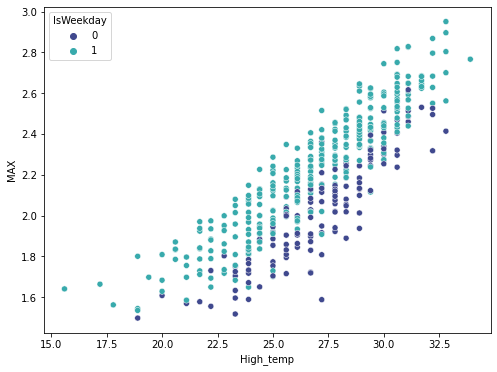

In [66]:
plt.figure(figsize = (8,6))

sns.scatterplot(x=df_summer["High_temp"], y=df_summer["MAX"],hue=df_summer["IsWeekday"], palette="mako")
plt.show()

What do you observe? Is this in line with you expectation?

Let us now train a new linear model with an additional feature for weekdays. As mentioned, all we need to do is to pass a larger feature vector to our linear model.

In [72]:
#y

In [75]:
X = df_summer[["High_temp", "IsWeekday"]]
y = df_summer[["MAX"]]
lin_mod_day = LinearRegression()
lin_mod_day.fit(X,y)
print(lin_mod_day.coef_, lin_mod_day.intercept_)

[[0.08541718 0.22431882]] [-0.28201097]


In [14]:
#X

**Question:** Note that we have now added a second element to our coefficient vector. Can you interpret the results?

Let us plot this

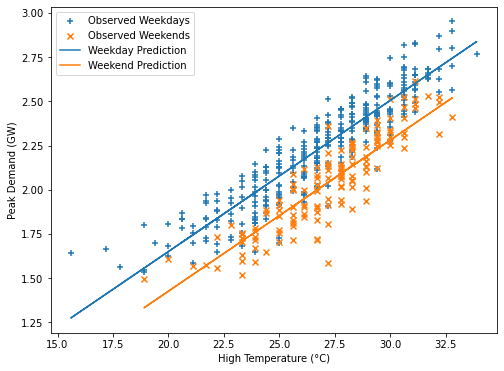

In [76]:
X_weekday = X[X["IsWeekday"]==1]
X_weekend = X[X["IsWeekday"]==0]

# predict weekends and weekdays seperately (usning same model!)
y_pred_weekday = lin_mod_day.predict(X_weekday)
y_pred_weekend = lin_mod_day.predict(X_weekend)

plt.figure(figsize = (8,6))

plt.scatter(X_weekday["High_temp"], 
            df_summer[df_summer["IsWeekday"]==True]["MAX"], 
            marker="+", label="Observed Weekdays")

plt.scatter(X_weekend["High_temp"], 
            df_summer[df_summer["IsWeekday"]==False]["MAX"], 
            marker="x", label="Observed Weekends")

plt.plot(X_weekday["High_temp"], 
         y_pred_weekday, 
         label="Weekday Prediction")
plt.plot(X_weekend["High_temp"], 
         y_pred_weekend, 
         label="Weekend Prediction")

plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")

plt.legend()
plt.show()

**Exercise**: How has the inclusion of an additional feature improved training performance? Report MAE, RMSE and $R^2$ of both model setups on the full dataset. Explain your results.

**Caution**: This is the training error! Do not confuse it with actual model predictive performance which can only be evaluated on unseen data!

In [79]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [80]:
# YOUR CODE HERE

# define X and y vectors
#target
y_true = df_summer["MAX"]
#features
X_1d = df_summer["High_temp"].values.reshape((-1,1)) # need to reshape 1d vector
X_2d = df_summer[["High_temp","IsWeekday"]]

#make predictions (models have already been fitted above!)
y_pred_1d = lin_mod.predict(X_1d)
y_pred_2d = lin_mod_day.predict(X_2d)


print("MAE 1D:", mean_absolute_error(y_true,y_pred_1d))
print("MAE 2D:", mean_absolute_error(y_true,y_pred_2d))

print("RMSE 1D:", mean_squared_error(y_true,y_pred_1d)**0.5)
print("RMSE 2D:", mean_squared_error(y_true,y_pred_2d)**0.5)

print("R2 1D:", r2_score(y_true,y_pred_1d))
print("R2 2D:", r2_score(y_true,y_pred_2d))

MAE 1D: 0.1259610051963046
MAE 2D: 0.09542776362321943
RMSE 1D: 0.1567504679751341
RMSE 2D: 0.1195172899949024
R2 1D: 0.7301181597178452
R2 2D: 0.8431019864973227


## `Non-linear modelling (polynomial regression)`

The relationship between high temperature and electrical demand is well-modelled by a linear function during the summer months, when (at least in Pittsburgh), electricity in summer is dominated by air conditioners (so with higher temperatures comes higher consumption). 

However, this is clearly not the case of the entire year. Indeed, if our previous linear model is to be believed then with lower temperatures we would continue to have lower and lower consumption (until, at some point, we’d start generating electricity). Naturally, this is not the case, and if we instead consider the entire year of high temperature and peak dmeand, or average temperature and average demand then another picture emerges.

Let us define the following common notation:

- xp = High temperature 
- yp = Peak demand 
- xa = Average temperature 
- ya = Average demand

In [83]:
# note that we know use the full data (not just summer)

xp = df["High_temp"].values
yp = df["MAX"].values
xa = df["Avg_temp"].values
ya = df["AVG"].values

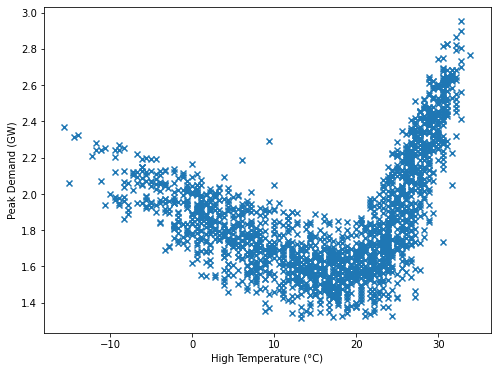

In [84]:
plt.figure(figsize = (8,6))
plt.scatter(xp, yp, marker="x")
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.show()

This captures the effects we expect. Although peak demand increases sharply with consumption after a high temperature of 22 degrees or so (precisely the range where air conditioning usually starts), below this the demand actually starts to increase with lower temperature – though not with as steep a slope, due to the fact, for example, that most heating in Pittsburgh is done with gas rather than with electricity, and other loads that do increase with lower temperatures tend to be smaller in magnitude than air conditioning units.

### Linear regression
If we were to fit a linear model to this data, it would look like the following:

The R^2 of linear regression is:  0.09387669129560838


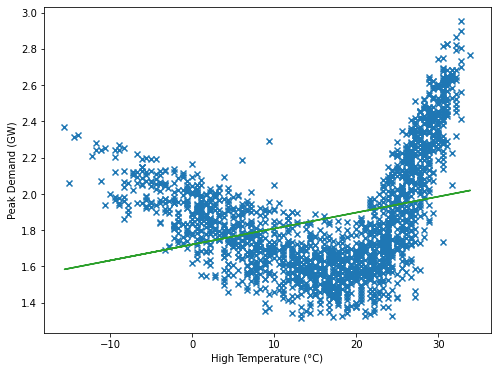

In [85]:
# initialize, fit and predict
lr = LinearRegression()
lr.fit(xp.reshape(-1,1), yp)
model_pred_p = lr.predict(xp.reshape(-1,1))

# plot figure
plt.figure(figsize = (8,6))
plt.scatter(xp, yp, marker="x" )
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.plot(xp, model_pred_p, c='C2')
print ('The R^2 of linear regression is: ',r2_score(yp, model_pred_p))

### Polynomial regression (quadratic)
To capture data of this type, we clearly want some way of expressing nonlinear relationships in the data.  Fortunately, this is possible without actually leaving the domain of so-called "linear regresion".  The trick we are going to use is a simple one: rather than have features $x^{(i)}$ which only include the "raw" inputs such as temperatuare (plus other raw inputs such as weekday indicators that we saw previously), we are going to make build features that include _nonlinear_ functions of the underlying inputs.  For example, we could choose the following features
\begin{equation}
x^{(i)} = \left [ \begin{array}{c} (\mathrm{HighTemperature}^{(i)})^2 \\
\mathrm{HighTemperature}^{(i)} \\ 1 \end{array} \right ]
\end{equation}
which also include a quadratic function of the high temperature variable.  If we choose this representation, then our linear hypothesis function $h_\theta(x) = \theta^Tx$ is now given by
\begin{equation}
h_\theta(x) = \theta_1 (\mathrm{HighTemperature}^{(i)})^2 + \theta_2 \mathrm{HighTemperature}^{(i)} + \theta_3
\end{equation}
which is a _quadratic_ function of the high temperature.  Importantly, however, the hypothesis function is still a linear function of the parameters, and so the exact same solution methods work as before (including the exact solution), just by passing a different feature matrix.

Let us first do this by hand. We define a simple function entitled `plot_regression_poly` that takes features, target and the degree of the polynomial as input.

In this setting we're actually going to standardize features to the range $[-1,+1]$ even with the exactly least-squares solution for numerical reasons.  High polynomials get very large very quickly, and if we aren't careful it's easy to overload the range of double precision floating point values.

To standardize to the range $[-1,+1]$ we use the following formula: 
\begin{equation}
2*\frac{x - min(x)}{max(x) - min(x)}-1
\end{equation}


In [86]:
# x is the input variable
# y is the output vaiable
# d is degree pf polynomial regression

def plot_regression_poly(x, y, d):
    
    # Create polynomial features
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x)-1  # standardize to range [-1,1]
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    
    # Implement polynomial regression using least squares (we use the nomal equations as derived in the lecture)
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    
    # create scaled test dataset
    xt = 2* (xt0 - min_x)/(max_x - min_x) -1
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T
    yt = Xt @ theta
    
    # Plot results
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:7]) # prints first 3 thetas

[ 1.19800453 -0.19250338  1.58898561]


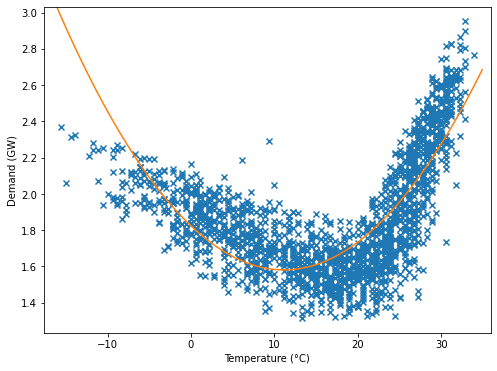

In [88]:
plot_regression_poly(x = xp, y=yp, d = 2)

This looks better, but quadratic function is symmetric around its minimum point, and the data we're trying to fit is definitely not symmetric. Thus, we may want a cubic function.

### Polynomial regression (Cubic)

[ 1.11163335  0.81686774 -0.59852881  1.64885721]


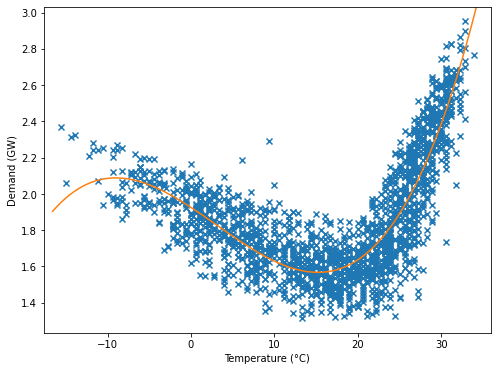

In [90]:
# Plot of Peak demand vs. High temperature
plot_regression_poly(x = xp, y=yp, d = 3)

Still not bad. Let's keep going:

[-1.68776194 -0.40786275  2.58744021  1.30044806 -0.1217828  -0.59596763
  1.69856294]


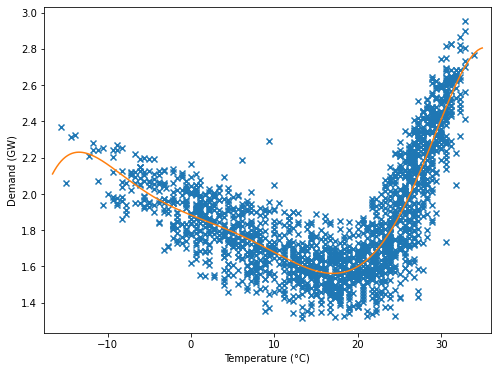

In [94]:
# Try some other values of d --> What seems to be a good one?

plot_regression_poly(x = xp, y=yp, d = 6)

How about a 100-degree polynomial? Is this something we want? Also, what do you think about the value of the coefficients?

[  423012.25188779  -322859.10419189   156741.65660648   258089.94078651
   173964.36936357    55591.27100741 -1252689.64681763]


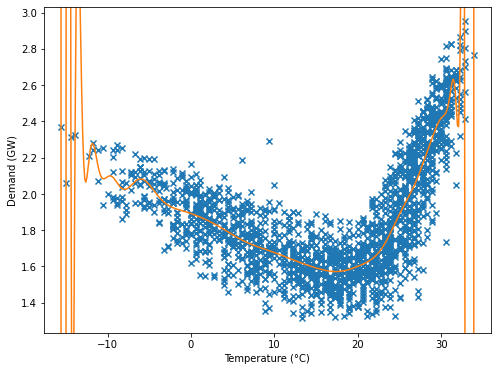

In [95]:
plot_regression_poly(x = xp, y=yp, d = 100)

Something very bad has happened at this point. Especially at the tail ends of the data, where the data points are spaced less closely, we start to get very odd patterns for the data. But the important point is that this is actually a very good fit to the data from a least-squares perspective. As you can see from the figure, the lines pass exactly through many of the data point (most obvious on the left hand side of the plot), whereas for the "better" fits we had above, our function didn't pass exactly through those points, so actually suffered more loss. But there is an obvious way in which the degree 100 polynomial fit, despite having lower loss, is actually a worse approximation to the underlying data. This brings us to the second topic of these notes, which is the issue of generlization and overfitting.

We will see shortly how we manage these situations, but let us first implement the above example using `scikit learn`. Essentially all we need to do is to pre-process our feature vector and create polynomial features. To do so we use a built-in module called `PolynomialFeatures`.

In [98]:
from sklearn.preprocessing import PolynomialFeatures

Let us first consider a toy example to understand how this module works

In [100]:
Q = np.array([[2,3,4], [5,6,7]])

#initialize PolynomialFeatures
PF = PolynomialFeatures(degree = 4,interaction_only = False, include_bias = True)
Q_Poly = PF.fit_transform(Q.reshape(-1,1))
print(Q)
print(Q_Poly)

[[2 3 4]
 [5 6 7]]
[[1.000e+00 2.000e+00 4.000e+00 8.000e+00 1.600e+01]
 [1.000e+00 3.000e+00 9.000e+00 2.700e+01 8.100e+01]
 [1.000e+00 4.000e+00 1.600e+01 6.400e+01 2.560e+02]
 [1.000e+00 5.000e+00 2.500e+01 1.250e+02 6.250e+02]
 [1.000e+00 6.000e+00 3.600e+01 2.160e+02 1.296e+03]
 [1.000e+00 7.000e+00 4.900e+01 3.430e+02 2.401e+03]]


**Note**: This will generate a new feature matrix consisting of all polynomial combinations
of the features with degree less than or equal to the specified degree. For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2]. This is slightly different from what we have done manually above but is a more common way of creating polynomial features.

In [103]:
def plot_regression_poly_scikit(X,Y,d):
    
    # initialize PolynomialFeatures
    poly_reg = PolynomialFeatures(degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly = LinearRegression()
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data (we have to transform the inputs as well!)
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.figure(figsize = (8,6))
    plt.scatter(X,Y,marker="x", c='C2')
    ylim = plt.ylim()
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([X.min()-2,X.max()+2]) # leave some space before and after limits
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    #print(lin_reg_Poly.coef_)

The R^2 for quadratic curve is:  0.7531939793344751


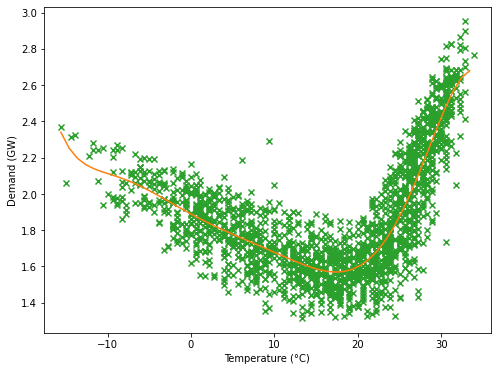

In [106]:
plot_regression_poly_scikit(X = xp, Y = yp, d = 8)

## `Generalization and overfitting`

Recall from our previous discussions that the canoncial machine learning problem that we solve with every algorithm is the following
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \; \frac{1}{m}\sum_{i=1}^m \ell \left(h_\theta(x^{(i)},y^{(i)} \right)
\end{equation}
i.e., to minimize the sum of losses on the data set.  However, in a more fundamental way, this is not really our goal.  We ultimately do not care about achieving low loss specifically on the points that we are feeding into the algorithm: we already _know_ the true output for each of these data points, and if we want to "predict" these points precisely, we could just look up each point in a database (assuming we have some way of referring to the points uniquely).  What we _really_ want from a machine learning algorithm is the ability to predict will on _new_ data points _of the same type_ as those we learned our model on.  We don't care about knowing was the peak demand _was_ on previous days we have already seen; we care about being able to predict what the peak demand will _be_ tomorrow given the high temperature as input.

**Generalization error** 

This discussion leads us to the notion of _generalization error_.  Informally, the generalization error is just the error (or more generally, the loss) we would experience not on the training data itself, but on new data drawn from the "same distirbution" as the training data.  _This_ is really the quantity we want to minimize, not the error on the training data itself.  Because when we run our machine learning algorithm on new data, all that will matter is its generalization performance.

What the above example illustrated was an instance of _overfitting_, the situation where the training error is low, but the generalization error is high.  This occurs because we are explicitly trying to minimize the loss on the training set, and if the expressiveness of of hypothesis function is small enough, then we can make this loss arbitrarily small, usually by fitting to pecularities in the training data that provide no real benefit when looking at new data.

**Overfitting and model complexity**

In general, we expect something like the following behavior when it comes to overfitting.  We're showing the "cartoon" form here but we will shortly see what this looks like in practice.

![Cartoon illustration of overfitting](overfitting.svg)

When model complexity is low, both training and generalization loss are high (here model complexity can mean any type of representational power of the model, but since we have covered this so far, you can think of it just as the degree of the polynomial in our feature vector).  As we increase model complexity, the both training and generalization performance start to decrease with training loss usually slightly lower that generalization loss (due to the simple fact tha we explicitly optimized training loss).  As we futher increase model complexity, training loss will continue to only decrease: by adding additional representational power to our model, we will only fit the data better and better, since we are explicitly choosing parameters to minimize this loss.  But at a certain point, generalization loss will start to increase again.  Our goal when choosing the "right" model for a particular machine learning problem is to find the model with lowest generalization error, the minimum in the red line above.  However, we cannot do so using the training set alone, because performance on the training set (the blue line), gives us no clue at to the performance of the generalization loss.

### Standard cross validation

The idea of cross validation is simple.  Given the entirety of our training data, we take some fixed percentage, say 70% of the data, and call this our "new" training set.  We then take the remaining data (30% in this case), and call it the _holdout_ or _validation_ set.  The basic idea is that we will use the emprical error or loss on this holdout set as an approximation for the generalization error.  This works because, unlike the training set, we do _not_ choose the parameters of the model based upon the validation set.  This means that there is no way for the parameters to overfit to this data, and thus the validation set still provides a reasonable estimate of generalization error even _after_ the parameters have been trained.

Let's see how to generate these training and validation sets.

#### Train-test split by hand

In [107]:
# create an array
X = df["High_temp"]

# create randomly shuffled list of indexes 
np.random.seed(10) # This method is called when RandomState is initialized
perm = np.random.permutation(len(X))

# select first 70% indexes of shuffled list as train set
idx_train = perm[:int(len(perm)*0.7)]

# select last 30% indexes of shuffled list as train set
idx_cv = perm[int(len(perm)*0.7):]

x_train, y_train = df["High_temp"].iloc[idx_train].values, df["MAX"].iloc[idx_train].values
x_cv, y_cv = df["High_temp"].iloc[idx_cv].values, df["MAX"].iloc[idx_cv].values

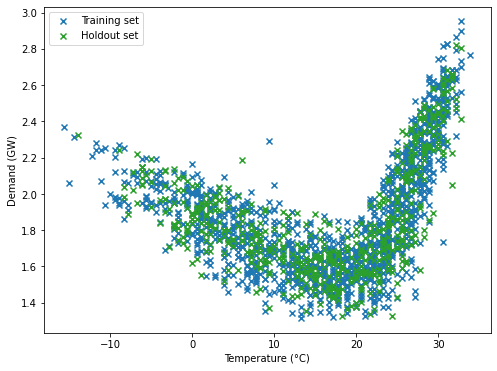

In [109]:
plt.figure(figsize = (8,6))
plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_cv, y_cv, marker='x', color="C2")
plt.xlabel("Temperature (°C)")
plt.ylabel("Demand (GW)")
plt.legend(['Training set', 'Holdout set'])
plt.show()
#plt.savefig('crossvalidation.png', dpi = 300)

In [110]:
len(x_train)

1277

In [111]:
len(x_cv)

548

#### Train-test split with `scikit learn`

We can also make our life earsier and use the `train_test_split` in `scikit learn`. 

In [114]:
from sklearn.model_selection import train_test_split

In [115]:
# split the data with 70-30% split as above
x_train, x_test, y_train, y_test = train_test_split(df["High_temp"], df["MAX"], test_size=0.3,random_state=42)

This gives us a very similar random test split (see figure below).

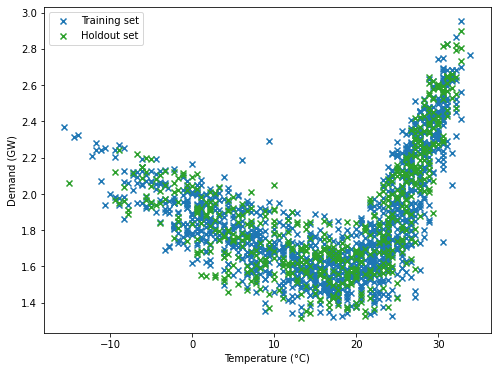

In [116]:
plt.figure(figsize = (8,6))
plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_test, y_test, marker='x', color="C2")
plt.xlabel("Temperature (°C)")
plt.ylabel("Demand (GW)")
plt.legend(['Training set', 'Holdout set'])
plt.show()
#plt.savefig('crossvalidation.pdf', dpi = 300)

In [117]:
len(x_train)

1277

In [118]:
len(x_test)

548

In [119]:
def ls_poly(x, y, d): #ls=lest squares
    
    # Create polynomial features
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x)-1  # standardize to range [-1,1]
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    
    # Implement polynomial regression using least squares (we use the nomal equations as derived in the lecture)
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    
    return theta

Text(0, 0.5, 'Mean squared error')

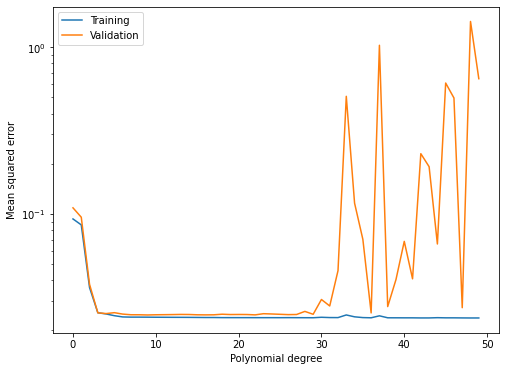

In [120]:
min_x_train, max_x_train = x_train.min(), x_train.max()
x_train = 2*(x_train - min_x_train)/(max_x_train - min_x_train) - 1
x_test = 2*(x_test - min_x_train)/(max_x_train - min_x_train) - 1

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T
    

err_train = []
err_cv = []
for i in range(50):
    theta = ls_poly(x_train, y_train, i)
    err_train.append(((poly_feat(x_train,i) @ theta - y_train)**2).mean())
    err_cv.append(((poly_feat(x_test,i) @ theta - y_test)**2).mean())

plt.figure(figsize = (8,6))
plt.semilogy(range(50), err_train, range(50), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

Let's zoom in on the "good" region...

Text(0, 0.5, 'Mean squared error')

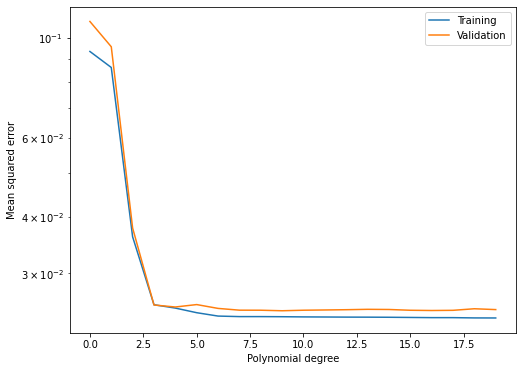

In [121]:
min_x_train, max_x_train = x_train.min(), x_train.max()
x_train = 2*(x_train - min_x_train)/(max_x_train - min_x_train) - 1
x_test = 2*(x_test - min_x_train)/(max_x_train - min_x_train) - 1

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T
    

err_train = []
err_cv = []
for i in range(20):
    theta = ls_poly(x_train, y_train, i)
    err_train.append(((poly_feat(x_train,i) @ theta - y_train)**2).mean())
    err_cv.append(((poly_feat(x_test,i) @ theta - y_test)**2).mean())

plt.figure(figsize = (8,6))    
plt.semilogy(range(20), err_train, range(20), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

**Exercise**: Re-produce the above graph for the case of predicting **average electical load** from **average temperature** using `scikit learn`. To do so follow the steps below:

- Define train and test datasets using `train_test_split`
- Define a polynomial model with variable degree inputs using `PolynomialFeatures` and `LinearModel`
- Write a simple loop to train the model for degrees ranging from 0-50 on the training dataset
- Compute and store the results in two sperate arrays (as done above)
- Plot your results

In [129]:
# YOUR CODE HERE

#define X and y vectors
xa = df["Avg_temp"]
ya = df["AVG"]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(xa, ya, test_size=0.3,random_state=42)

Text(0, 0.5, 'Mean squared error')

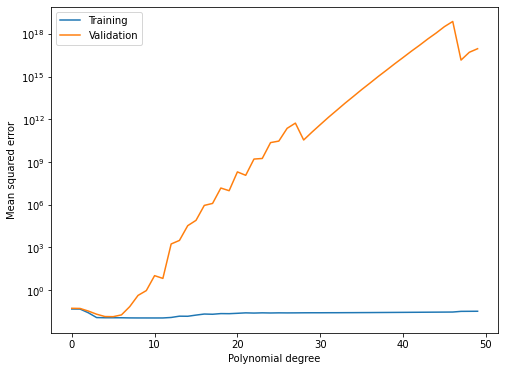

In [130]:
# YOUR CODE HERE
#define loop 
err_train = []
err_cv = []
for deg in range(50): # we want to loop across 0-50 degrees
    
    # create poly features
    poly_feat = PolynomialFeatures(degree=deg) #initialize
    
    X_train_poly=poly_feat.fit_transform(X_train.values.reshape((-1,1)))
    X_test_poly=poly_feat.fit_transform(X_test.values.reshape((-1,1)))
    
    # initialize and fit model
    lin_mod_poly = LinearRegression()
    lin_mod_poly.fit(X_train_poly,y_train)
    
    # compute errors and append to err_train and err_cv
    err_train.append(mean_squared_error(y_train,lin_mod_poly.predict(X_train_poly)))
    err_cv.append(mean_squared_error(y_test,lin_mod_poly.predict(X_test_poly)))

# plot results
plt.figure(figsize = (8,6))    
plt.semilogy(range(50), err_train, range(50), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

Note that the error curve naturaly looks slightly different from above since our targets and predictors are the average load and temperature respectively.

### Cross validation using train/holdout/test splits

As we have discussed in last week's lecture it is advisable to actually do a three-ways split of the dataset to avoid leakage. You would typically do the following:

1. Divide data into training
set, holdout set, and test
set
2. Train algorithm on training
set (i.e., to learn
parameters), use holdout
set to select
hyperparameters
3. (Optional) retrain system
on training + holdout
4. Evaluate performance on
test set

Naturally, as above, we can do the split manually. Here is the code:

In [122]:
# create an array
X = df["High_temp"]

# create randomly shuffled list of indexes 
np.random.seed(10) # This method is called when RandomState is initialized
perm = np.random.permutation(len(X))

# select first 70% indexes of shuffled list as train set
idx_train = perm[:int(len(perm)*0.5)]

# select last 30% indexes of shuffled list as train set
idx_hold= perm[int(len(perm)*0.5):int(len(perm)*0.7)]

# select last 30% indexes of shuffled list as train set
idx_test= perm[int(len(perm)*0.7):int(len(perm)*1)]

x_train, y_train = df["High_temp"].iloc[idx_train].values, df["MAX"].iloc[idx_train].values
x_hold, y_hold = df["High_temp"].iloc[idx_hold].values, df["MAX"].iloc[idx_hold].values
x_test, y_test = df["High_temp"].iloc[idx_test].values, df["MAX"].iloc[idx_test].values

In [123]:
print(len(x_train),len(x_hold),len(x_test))

912 365 548


But we can do it in `scikit learn` a bit more easily. Please have a go yourself.

**Exercise**: Create a train/holdout/test set of with respective proportions of 50%, 20% and 30% using `scikit learn's` `train_test_split` module consecutively. Visualize your results.

In [124]:
# YOUR CODE HERE
#Do a 70-30 split first
X_train, X_test, y_train, y_test = train_test_split(xp, yp, test_size=0.3,random_state=34 )

# now split X_train to achive 50-20-30 split
X_train, X_hold, y_train, y_hold = train_test_split(X_train, y_train, test_size=(0.2/0.7),random_state=34 )

In [125]:
print(len(X_train),len(X_hold),len(X_test))

912 365 548


Text(0, 0.5, 'Mean squared error')

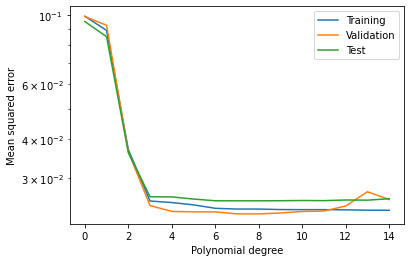

In [126]:
min_x_train, max_x_train = X_train.min(), X_train.max()
x_train = 2*(X_train - min_x_train)/(max_x_train - min_x_train) - 1
x_hold = 2*(X_hold - min_x_train)/(max_x_train - min_x_train) - 1
x_test = 2*(X_test - min_x_train)/(max_x_train - min_x_train) - 1

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T
    

err_train = []
err_hold = []
err_test = []
for i in range(15):
    theta = ls_poly(x_train, y_train, i)
    err_train.append(((poly_feat(x_train,i) @ theta - y_train)**2).mean())
    err_hold.append(((poly_feat(x_hold,i) @ theta - y_hold)**2).mean())
    err_test.append(((poly_feat(x_test,i) @ theta - y_test)**2).mean())
plt.semilogy(range(15), err_train, range(15), err_hold,range(15), err_test)
plt.legend(["Training", "Validation", "Test"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

### Further validation techniques

There is a whole range of more or less evolved validation techniques. For most of these pre-built implementations in scikit learn exist. We refer you to the excellent scikit learn cross validation page for further reading. You can access it [here](https://scikit-learn.org/stable/modules/cross_validation.html). The most important technique to check out is k-fold cross-validation.

---